# Multiple trials

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport algebra
%aimport util
%aimport inference
%aimport link
%aimport graph
%precision 4

'%.4f'

In [2]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph
from algebra import ichol_gauss, subspace

In [3]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
GPVBcolor = sns.xkcd_rgb["denim blue"]

In [5]:
# dimensions
nsample = 10
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

## Generate latent

### Lorenz attractor

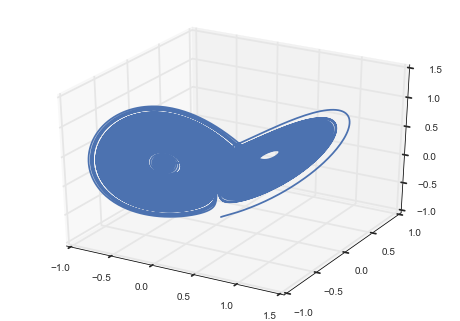

In [6]:
np.random.seed(0)
wait = 500
lorenz = simulation.lorenz(wait + nsample * ntrial * ntime, dt=3e-3, x0=np.random.random(3))
lorenz = (lorenz - lorenz.mean(axis=0)) / norm(lorenz, axis=0, ord=np.inf)
x = lorenz[wait:, :].reshape((nsample, ntrial, ntime, -1))

Simulate spike trains

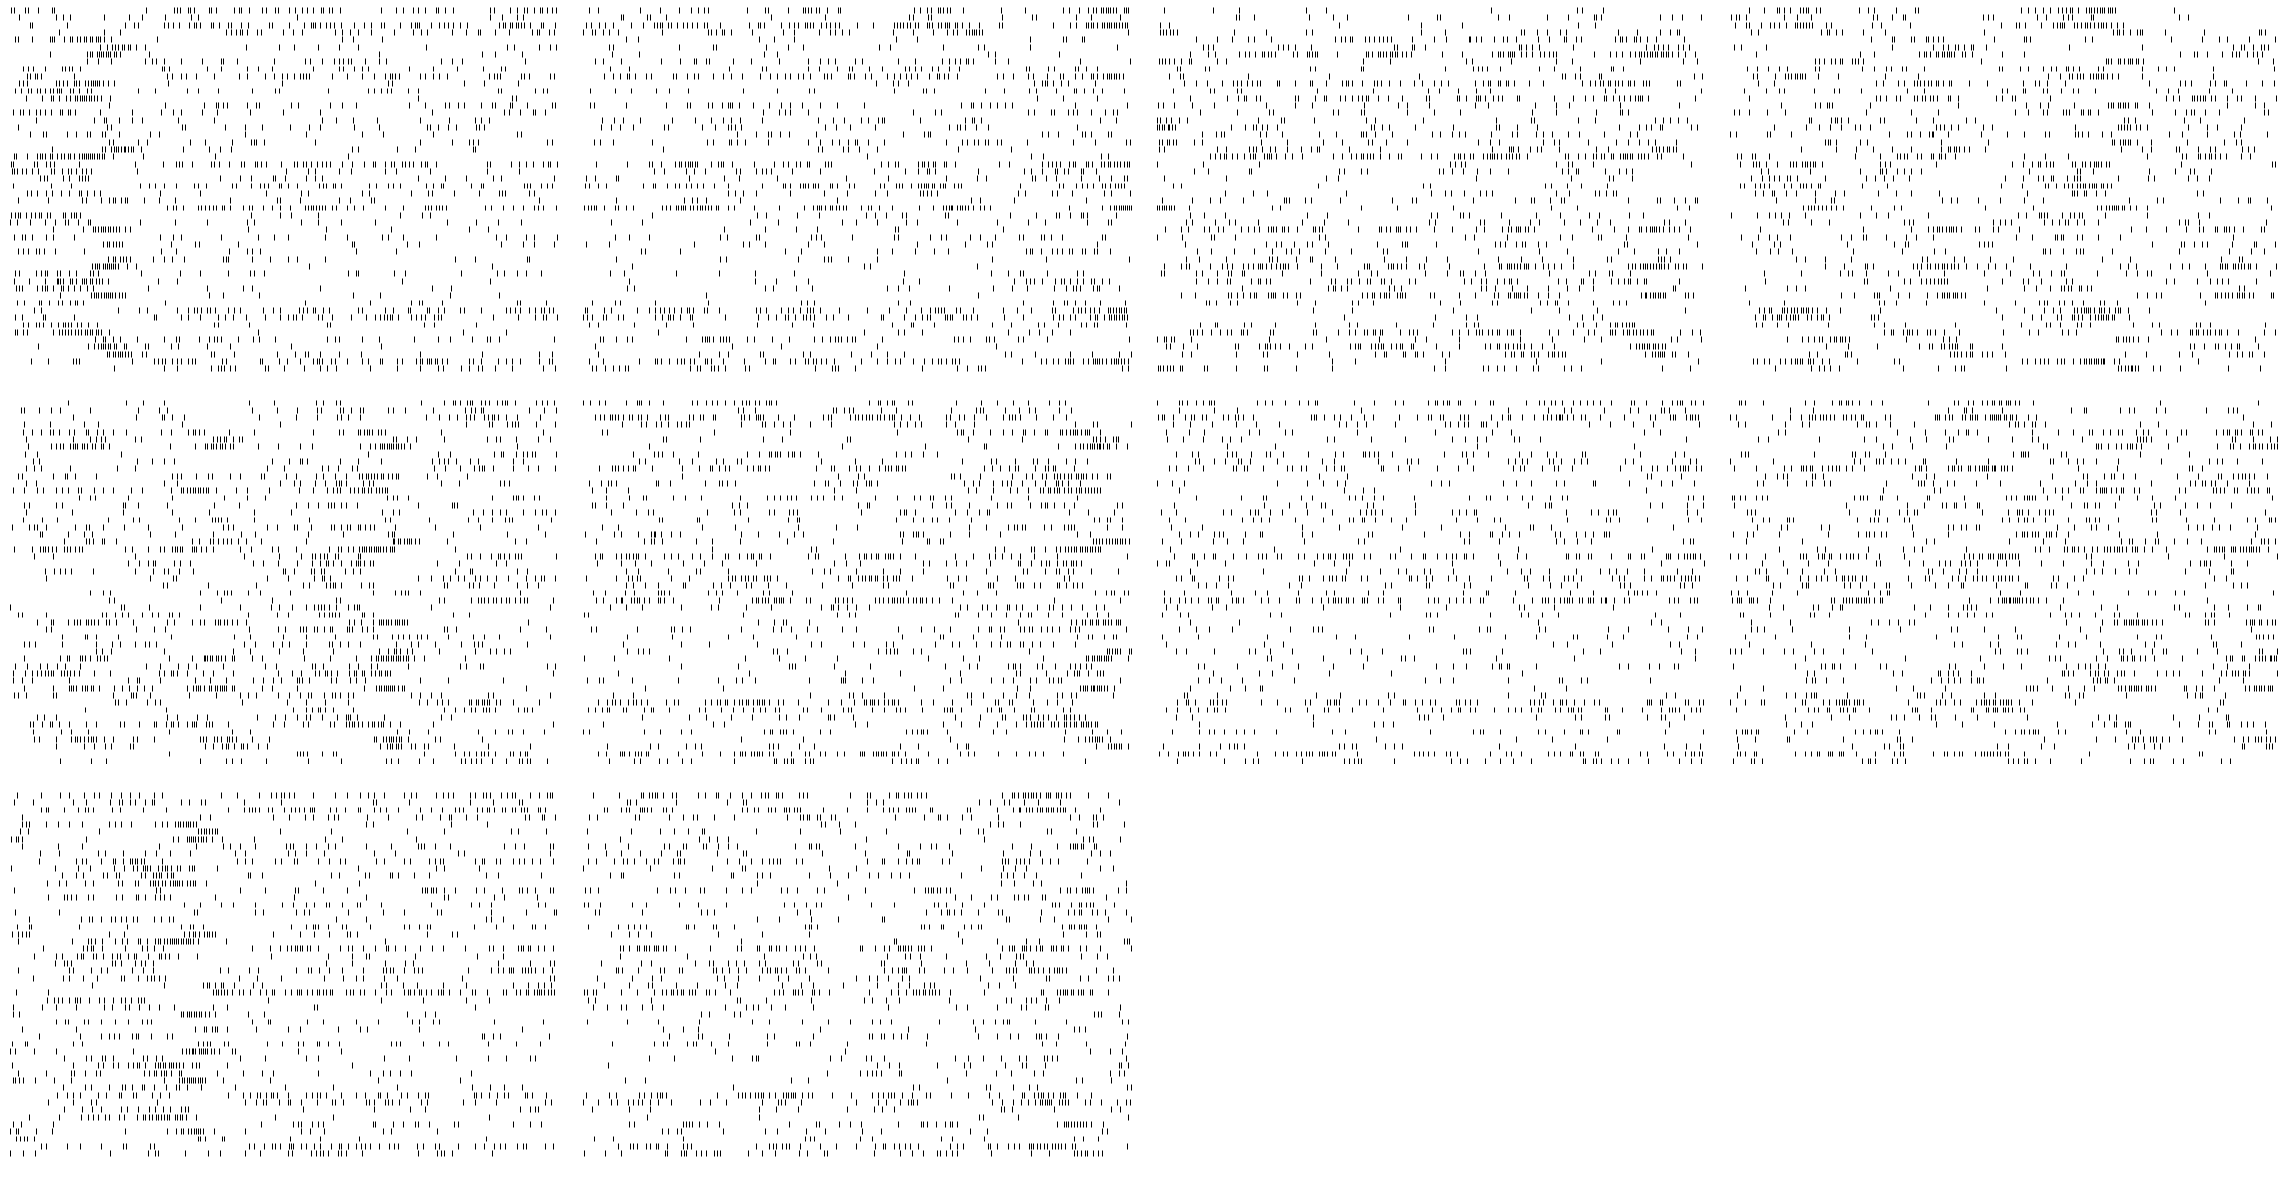

In [20]:
np.random.seed(0)
low = np.log(20 / ntime)
aspk = (np.random.rand(nlatent, nspike) + 1.5) * np.sign(np.random.randn(nlatent, nspike))
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike)))
for i in range(nsample):
    y, _, _ = simulation.spike(x[i, :], aspk, bspk)
    sample = {'y': y, 'x': x[i, :], 'a': aspk, 'b':bspk}
    savemat('data/sample_lorenz{}'.format(i), sample)
graph.rasterplot(y);

Load samples

In [21]:
fsample = ['data/sample_lorenz{}'.format(s) for s in range(nsample)]

In [ ]:
sigma = np.full(nlatent, fill_value=1.0)
omega = np.full(nlatent, fill_value=5e-4)

vLGPAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(fsample):
    print('Sample {}'.format(i + 1))
    sample = loadmat(fname)
    result = inference.multitrials(sample['y'], None, sigma, omega, x=sample['x'], ta=sample['a'], tb=sample['b'], lag=3, rank=100, tol=1e-5)
    savemat(fname + 'vLGP', result)
    df = pd.DataFrame(np.vstack((result['stat']['latentAngle'][1:] * 180 / np.pi, 
                      result['stat']['loadingAngle'][1:] * 180 / np.pi, 
                      np.cumsum(result['stat']['elapsed'][1:,2]))).T, columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'vLGP'
    df['Sample'] = i
    vLGPAngle = vLGPAngle.append(df)

Sample 1

Inference starting
Iteration[1], posterior elapsed: 0.70, parameter elapsed: 0.65, total elapsed: 1.64, ELBO: -222741.9795
Iteration[2], posterior elapsed: 0.69, parameter elapsed: 0.65, total elapsed: 1.62, ELBO: -117694.7361
Iteration[3], posterior elapsed: 0.69, parameter elapsed: 0.65, total elapsed: 1.62, ELBO: -85707.0731
Iteration[4], posterior elapsed: 0.68, parameter elapsed: 0.65, total elapsed: 1.62, ELBO: -77991.3105
Iteration[5], posterior elapsed: 0.68, parameter elapsed: 0.65, total elapsed: 1.62, ELBO: -76525.5802
Iteration[6], posterior elapsed: 0.68, parameter elapsed: 0.65, total elapsed: 1.62, ELBO: -75916.8358
Iteration[7], posterior elapsed: 0.69, parameter elapsed: 0.68, total elapsed: 1.66, ELBO: -75440.1769
Iteration[8], posterior elapsed: 0.69, parameter elapsed: 0.65, total elapsed: 1.62, ELBO: -75018.4738
Iteration[9], posterior elapsed: 0.69, parameter elapsed: 0.68, total elapsed: 1.66, ELBO: -74610.2527
Iteration[10], posterior elapsed: 0.69, pa

In [ ]:
vLGPlast = vLGPAngle.groupby('Sample').last()
bestvLGP = vLGPlast.ix[vLGPlast['LatentAngle'].idxmin()]
ibestvLGP = int(bestvLGP.name)

print(bestvLGP)

bestvLGPx = loadmat('data/sample_lorenz{}vLGP'.format(ibestvLGP))['posterior']['mu'][0,0]

rotated = util.rotate(bestvLGPx.reshape((-1, nlatent)), x[ibestvLGP,:].reshape((-1, nlatent)))
fig = plt.figure()
ax = fig.gca(projection='3d')
recon = rotated
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('vLGP Reconstruction {}'.format(ibestvLGP + 1));
plt.savefig('figure/vLGP.pdf');

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x[ibestvLGP,:].reshape((-1, nlatent))[:, 0], x[ibestvLGP,:].reshape((-1, nlatent))[:, 1], x[ibestvLGP,:].reshape((-1, nlatent))[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('True latent {}'.format(ibestvLGP + 1));

In [156]:
# Run GPFA before loading GPFA results
GPFAresult = ['data/sample_lorenz{}GPFA'.format(s) for s in range(nsample)]
GPFAAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(GPFAresult):
    GPFA = loadmat(fname)
    df = pd.DataFrame(np.hstack((GPFA['latentAngles'] * 180 / np.pi, 
                      GPFA['loadingAngles'] * 180 / np.pi, 
                      np.cumsum(GPFA['iterTime'])[...,None])), columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'GPFA'
    df['Sample'] = i
    GPFAAngle = GPFAAngle.append(df)

LatentAngle     45.5568
LoadingAngle    61.1129
Time            17.0214
Model              GPFA
Name: 2.0, dtype: object


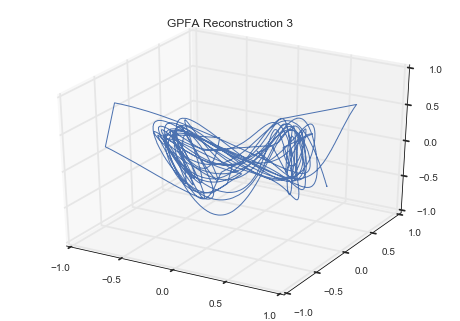

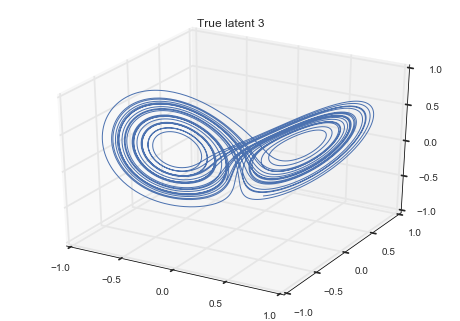

In [167]:
GPFAlast = GPFAAngle.groupby('Sample').last()
bestGPFA = GPFAlast.ix[GPFAlast['LatentAngle'].idxmin()]
print(bestGPFA)

ibestGPFA = int(bestGPFA.name)
bestGPFAresult = loadmat('data/sample_lorenz{}GPFA'.format(ibestGPFA))
bestGPFAx = np.rollaxis(np.dstack(np.squeeze(bestGPFAresult['seqTrain']['xsm'])), axis=-1).transpose((0, 2,1))

rotated = util.rotate(bestGPFAx.reshape((-1, nlatent)), x[ibestGPFA,:].reshape((-1, nlatent)))
fig = plt.figure()
ax = fig.gca(projection='3d')
recon = rotated
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('GPFA Reconstruction {}'.format(ibestGPFA + 1));
plt.savefig('figure/GPFARecon.pdf');

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x[ibestGPFA,:].reshape((-1, nlatent))[:, 0], x[ibestGPFA,:].reshape((-1, nlatent))[:, 1], x[ibestGPFA,:].reshape((-1, nlatent))[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('True latent {}'.format(ibestGPFA + 1));

In [162]:
# Run PLDS before loading PLDS results
PLDSresult = ['data/sample_lorenz{}PLDS'.format(s) for s in range(nsample)]
PLDSAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(PLDSresult):
    PLDS = loadmat(fname)
    df = pd.DataFrame(np.hstack((PLDS['latentAngles'] * 180 / np.pi, 
                      PLDS['loadingAngles'] * 180 / np.pi, 
                      np.cumsum(PLDS['StepTimes'])[...,None])), columns=['LatentAngle', 'LoadingAngle', 'Time'])
    df['Model'] = 'PLDS'
    df['Sample'] = i
    PLDSAngle = PLDSAngle.append(df)

LatentAngle     37.1302
LoadingAngle    21.0036
Time             595.62
Model              PLDS
Name: 7.0, dtype: object


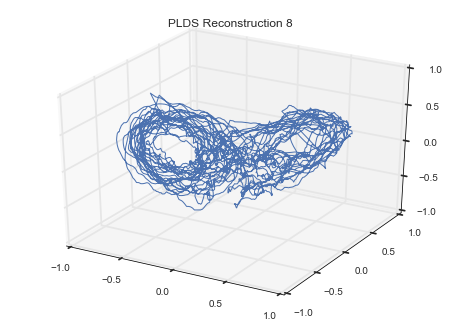

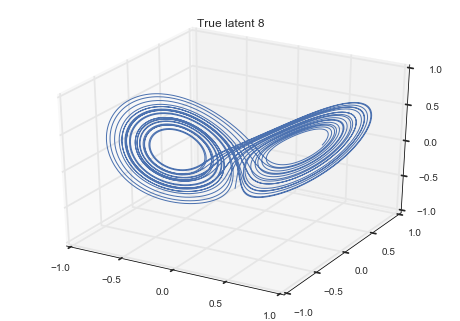

In [166]:
PLDSlast = PLDSAngle.groupby('Sample').last()
bestPLDS = PLDSlast.ix[PLDSlast['LatentAngle'].idxmin()]
print(bestPLDS)

ibestPLDS = int(bestPLDS.name)
bestPLDSresult = loadmat('data/sample_lorenz{}PLDS'.format(ibestPLDS))
bestPLDSx = np.squeeze(bestPLDSresult['xsm']).T.reshape(ntrial, -1, nlatent)

rotated = util.rotate(bestPLDSx.reshape((-1, nlatent)), x[ibestPLDS, :].reshape((-1, nlatent)))
fig = plt.figure()
ax = fig.gca(projection='3d')
recon = rotated
ax.plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('PLDS Reconstruction {}'.format(ibestPLDS + 1));
plt.savefig('figure/PLDS.pdf')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x[ibestPLDS,:].reshape((-1, nlatent))[:, 0], x[ibestPLDS,:].reshape((-1, nlatent))[:, 1], x[ibestPLDS,:].reshape((-1, nlatent))[:, 2], lw=1);
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
plt.title('True latent {}'.format(ibestPLDS + 1));

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


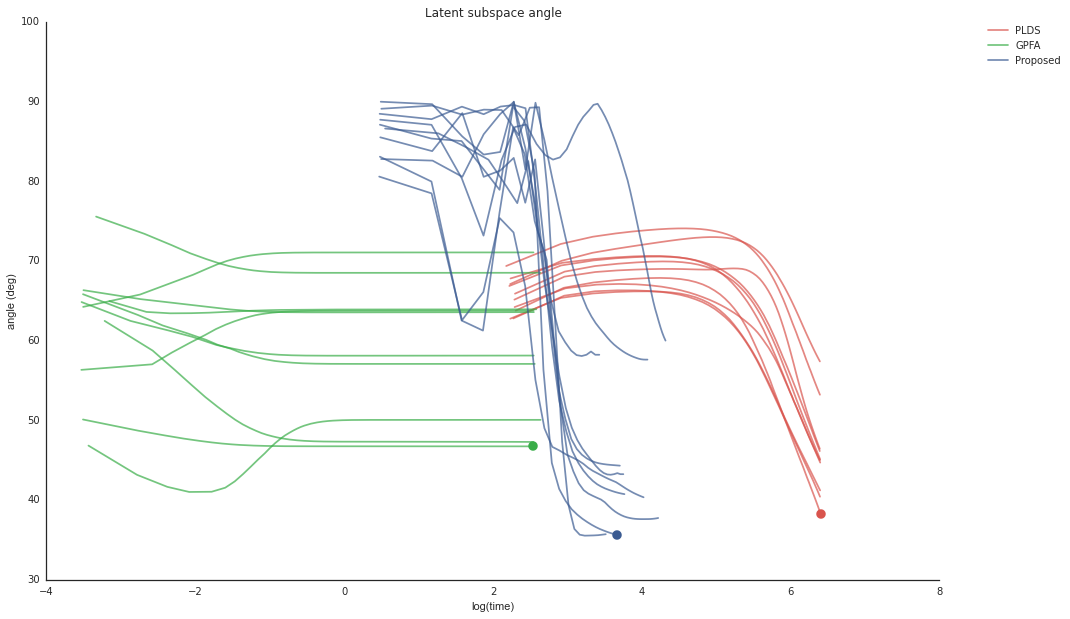

In [461]:
# Latent subspace angle plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
for key, grp in PLDSAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=PLDScolor, alpha=0.7);
for key, grp in GPFAAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=GPFAcolor, alpha=0.7);
for key, grp in ProposedAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LatentAngle'], color=GPVBcolor, alpha=0.7);

PLDSgrp = PLDSAngle.groupby('Sample')
angle = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['LatentAngle']
time = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=PLDScolor, lw=5)
    
GPFAgrp = GPFAAngle.groupby('Sample')
angle = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['LatentAngle']
time = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPFAcolor, lw=5)

GPVBgrp = GPVBAngle.groupby('Sample')
angle = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['LatentAngle']
time = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPVBcolor, lw=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlim([-4, 8])
plt.xlabel('log(time)');
plt.ylabel('angle (deg)');
PLDSline = mlines.Line2D([], [], color=PLDScolor, alpha=0.7, label='PLDS');
GPFAline = mlines.Line2D([], [], color=GPFAcolor, alpha=0.7, label='GPFA');
GPVBline = mlines.Line2D([], [], color=GPVBcolor, alpha=0.7, label='Proposed');
plt.legend(handles=[PLDSline, GPFAline, GPVBline], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.title('Latent subspace angle');
plt.savefig('figure/latent.pdf')

/Users/yuan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


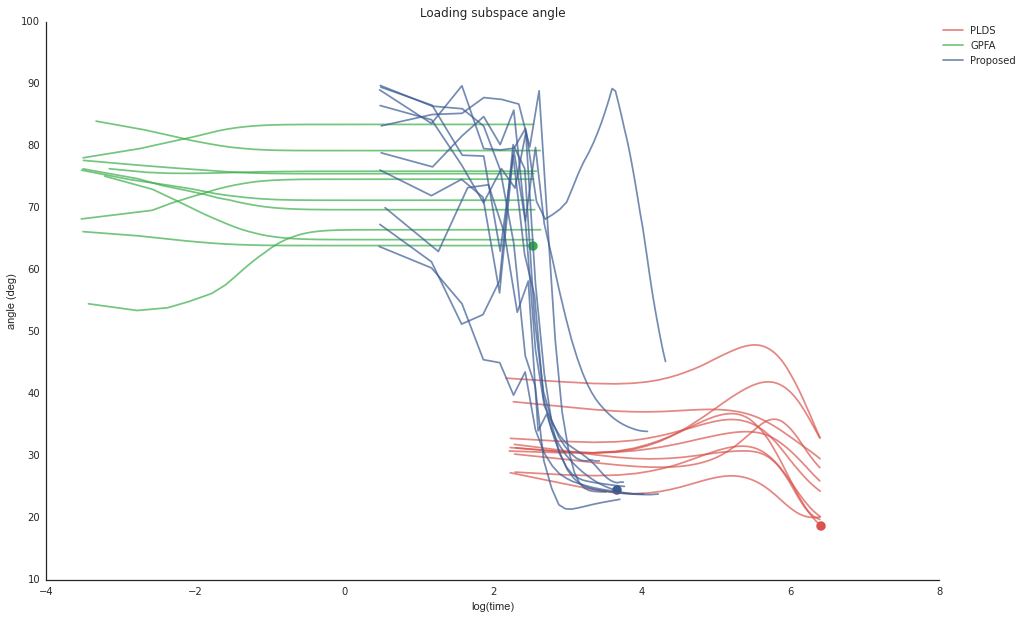

In [460]:
# Loading subspace angle plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
for key, grp in PLDSAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=PLDScolor, alpha=0.7);
for key, grp in GPFAAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=GPFAcolor, alpha=0.7);
for key, grp in ProposedAngle.groupby('Sample'):
    ax.plot(np.log(grp['Time']), grp['LoadingAngle'], color=GPVBcolor, alpha=0.7);

PLDSgrp = PLDSAngle.groupby('Sample')
angle = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['LoadingAngle']
time = PLDSgrp.get_group(ibestPLDS).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=PLDScolor, lw=5)
    
GPFAgrp = GPFAAngle.groupby('Sample')
angle = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['LoadingAngle']
time = GPFAgrp.get_group(ibestGPFA).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPFAcolor, lw=5)

GPVBgrp = GPVBAngle.groupby('Sample')
angle = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['LoadingAngle']
time = GPVBgrp.get_group(ibestGPVB).dropna().tail(1)['Time']
ax.scatter(np.log(time), angle, color=GPVBcolor, lw=5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlim([-4, 8])
plt.xlabel('log(time)');
plt.ylabel('angle (deg)');
PLDSline = mlines.Line2D([], [], color=PLDScolor, alpha=0.7, label='PLDS');
GPFAline = mlines.Line2D([], [], color=GPFAcolor, alpha=0.7, label='GPFA');
GPVBline = mlines.Line2D([], [], color=GPVBcolor, alpha=0.7, label='Proposed');
plt.legend(handles=[PLDSline, GPFAline, GPVBline], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.);
plt.title('Loading subspace angle');
plt.savefig('figure/loading.pdf')

In [43]:
sample = loadmat('data/sample_lorenz9')
yhat = np.empty_like(sample['y'])
for i in range(sample['y'].shape[0]):
    model = inference.gpvb(sample['y'], None, sigma, omega, rank=100, x=sample['x'], lag=3, truea=sample['a'], trueb=sample['b'], testidx=[i], tol=1e-5)
    yhat[i, :, :] = model['test']['yhat']
prediction = {'y':sample['y'], 'yhat': yhat}
savemat('data/sample_lorenz9GPVBpred', prediction)


Inference starting
Iteration[1], posterior elapsed: 0.62, parameter elapsed: 0.64, total elapsed: 1.52, ELBO: -201114.0217
Iteration[2], posterior elapsed: 0.62, parameter elapsed: 0.76, total elapsed: 1.65, ELBO: -106680.5018
Iteration[3], posterior elapsed: 0.62, parameter elapsed: 0.64, total elapsed: 1.52, ELBO: -77945.1876
Iteration[4], posterior elapsed: 0.61, parameter elapsed: 0.63, total elapsed: 1.50, ELBO: -70886.3323
Iteration[5], posterior elapsed: 0.79, parameter elapsed: 0.65, total elapsed: 1.71, ELBO: -68941.7030
Iteration[6], posterior elapsed: 0.63, parameter elapsed: 0.65, total elapsed: 1.54, ELBO: -67486.4704
Iteration[7], posterior elapsed: 0.64, parameter elapsed: 0.84, total elapsed: 1.75, ELBO: -66521.5965
Iteration[8], posterior elapsed: 0.66, parameter elapsed: 0.73, total elapsed: 1.66, ELBO: -65943.2448
Iteration[9], posterior elapsed: 0.63, parameter elapsed: 0.72, total elapsed: 1.61, ELBO: -65586.1410
Iteration[10], posterior elapsed: 0.79, parameter e

In [105]:
result['posterior']['mu'][0,0].shape

(10, 1000, 3)

In [109]:
bestGPVBx.reshape((-1, nlatent)).shape

(10000, 3)